## Setup

In [63]:
import torch
import numpy as np
import os, sys, time 
import pandas as pd
import zipfile, tarfile, requests  # TODO: Ensure package requests is installed

import matplotlib.pyplot as plt

In [64]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from patsy import dmatrices
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

# packages required for k-means and PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [65]:
# packages required for proecessing zip files
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# packages for plots and graphs
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import requests, zipfile

In [66]:
!pip install kaggle

In [67]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download ellipticco/elliptic-data-set

elliptic-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [68]:
def getData():
    with ZipFile("elliptic-data-set.zip") as zfile:
        df_node_transactions = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_classes.csv'))
        df_edge_payments = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv'))
        df_features = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_features.csv'))
    return df_node_transactions,df_edge_payments,df_features

The dataset consists of 203,769 transactions, of which 21% are
labeled as licit, and 2% as illicit, based on the category of the bitcoin
address that created the transaction. The remaining transactions
are unlabeled. Illicit categories include scams, malware, terrorist organizations, and Ponzi schemes. Licit categories include exchanges,
wallet providers, miners, and licit services. Each transaction has 166
features, 94 of which represent information about the transaction
itself. The remaining features were constructed 
using information one-hop backward/forward from the transaction,
such as the minimum, maximum, and standard deviation of each
transaction feature. All features, except for the time-step, are fully
anonymized and standardized with zero mean and unit variance.

In [69]:
df_node_transactions,df_edge_payments,df_features = getData()

Nodes and Edges. There are 203,769 node transactions and
234,355 directed edge payments flows. 

In [70]:
df_node_transactions.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [71]:
df_edge_payments.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


Features. Each node has associated 166 features. The first 94
features represent local information about the transaction – including the time step, number of inputs/outputs, transaction fee, output
volume and aggregated figures such as average BTC received (spent)
by the inputs/outputs and average number of incoming (outgoing)
transactions associated with the inputs/outputs. The remaining 72
features, called aggregated features, are obtained by aggregating
transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and
correlation coefficients of the neighbour transactions for the same
information data (number of inputs/outputs, transaction fee, etc.).

In [72]:
df_features.head()

,230425980,1,-0.1714692896288031,-0.18466755143291433,-1.2013688016765636,-0.12196959975910057,-0.04387454791734898,-0.11300200928476244,-0.06158379407303222,-0.16209679981659642,-0.16793302645225652,-0.04970696439403985,-0.16440217329951,-0.028741285856664783,-0.035390552600813516,-0.042955299258028254,-0.013281614870058885,-0.057194633660791555,-0.16960915015560768,-0.17115370708833458,-0.1744725474413385,-1.3736571773938961,-1.3714598276027399,-0.13973120192279553,-0.1489118870463073,-0.08014726965335221,-0.15566142432803598,-0.010763009512837094,-0.012107451777478418,-0.13973300164963834,-0.14890718609704007,-0.08014673584659182,-0.1556613943053229,-0.0106685610738475,-0.012005182118417812,-0.02466883065625352,-0.031272390486630317,-0.0230451563960962,-0.026214655177430907,0.001427813709709475,...,-0.09771859912616487,-0.12746225048300552,0.0031432964315106413,0.0024263098865888125,-0.1209504155034722,-0.19914489882884956,-0.18799267262971858,-0.21294750674116758,1.0642045463479908,1.0637874876466933,-1.3737824923785267,-1.3547347717590499,-0.29797501416794375,-1.4036981050621322,1.342003002186918,1.3407327277377104,-0.17160149344087147,-0.4581618412195745,-0.4235879631572251,-0.44088282778065335,-1.0159633735173061,-1.0162304272806977,-0.968902874660573,-0.37571453141267186,0.759748200156594,-0.7683292540299814,1.4881129012284324,1.487932476808418,-0.21681436061843226,-0.6056310578523486,-0.5621534802884299,-0.6009988905192808,1.4613303209554889,1.4613689382001922,0.01827940003744589,-0.0874901561101501,-0.13115530389558736,-0.09752359377152515,-0.12061340670311574,-0.11979245961251665
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.2013

In [73]:
colNames1 = {'0': 'txId', '1': "Time step"}
colNames2 = {str(i+2): "Local_feature_" + str(i+1) for i in range(93)}
colNames3 = {str(j+95): "Aggregate_feature_" + str(j+1) for j in range(72)}
#combine dictionaries
colNames = dict(**colNames1, **colNames2, **colNames3 )

In [74]:
df_features.columns = colNames.values()
df_features.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,...,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057

In [75]:
print('Shape of classes', df_node_transactions.shape)
print('Shape of edges', df_edge_payments.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203768, 167)


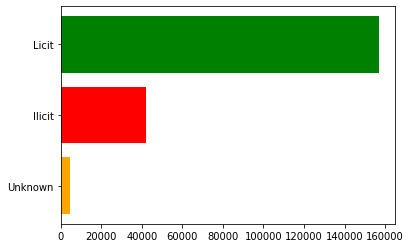

In [76]:
df_node_transactions.loc[df_node_transactions['class'] == 'unknown', 'class'] = '3'
group_class = df_node_transactions.groupby('class').count()
plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, \
         color=['orange', 'r', 'g'] );

### Number of transactions per Time step

Text(0.5, 1.0, 'Number of transactions by Time step')

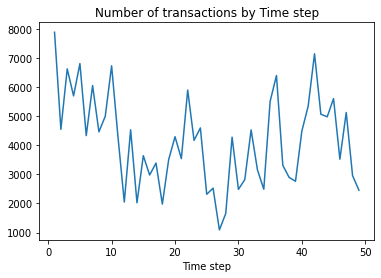

In [77]:
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

In [78]:
print(len(df_node_transactions.txId.unique()))
len(df_features.txId.unique())

203769


203768

In [79]:
# Merge Class and features
df_nodetrans_feature = pd.merge(df_features,df_node_transactions, on='txId',how='left' )

df_nodetrans_feature.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,...,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,3
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,3
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065

In [80]:
nodetrans_feature = df_nodetrans_feature.groupby(['Time step', 'class']).count()
nodetrans_feature = nodetrans_feature['txId'].reset_index().\
rename(columns={'txId': 'count'})#unstack()
nodetrans_feature.head()

,Time step,class,count
0,1,1,17
1,1,2,2130
2,1,3,5732
3,2,1,18
4,2,2,1099


Text(0.5, 0, 'Time step')

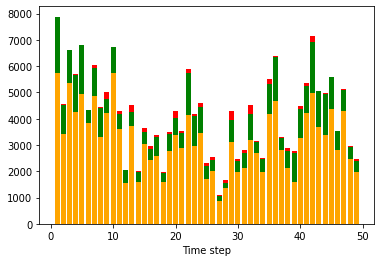

In [81]:
class1 = nodetrans_feature[nodetrans_feature['class'] == '1']
class2 = nodetrans_feature[nodetrans_feature['class'] == '2']
class3 = nodetrans_feature[nodetrans_feature['class'] == '3']

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'])

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time step')

##  Train Test split


The train set includes all labeled samples up to the 34th time-step (29894 transactions), and the test set includes all labeled samples from the 35th time-step, inclusive, onward (16670
transactions)

In [82]:
data = df_nodetrans_feature.loc[df_nodetrans_feature['class'].isin(('1','2'))]
X = data.drop(['class','txId'], axis=1)
y = data['class']
y = np.where(y=='2',0,1)
print('X shape: {}'.format(X.shape))
print('y count:\n{}'.format(pd.value_counts(y)))

X shape: (46564, 166)
y count:
0    42019
1     4545
dtype: int64


In [83]:
def paper_split(X, y, all_test=False):
  X_train = X[X['Time step'] <= 34]
  y_train = y[X['Time step'] <= 34]
  if all_test:
    X_test = X.copy()
    y_test = y.copy()
  else:
    X_test = X[X['Time step'] >= 35]
    y_test = y[X['Time step'] >= 35]

  y_test_timestep = X_test.copy()['Time step']
  X_train.drop(['Time step'], axis=1, inplace=True)
  X_test.drop(['Time step'], axis=1, inplace=True)

  print('Paper split')
  print('training data shape: {}'.format(X_train.shape))
  print('test data shape: {}'.format(X_test.shape))

  print('y training data count:')
  print(pd.value_counts(y_train))
  print('y test data count:')
  print(pd.value_counts(y_test))

  return (X_train, X_test, y_train, y_test, y_test_timestep)
  

In [84]:
from sklearn.model_selection import train_test_split
def experimental_split(X, y, all_test=False):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3580, random_state=42)

  if all_test:
    X_test = pd.concat([X_train,X_test])
    y_test = np.concatenate((y_train, y_test))

  y_test_timestep = X_test.copy()
  y_test_timestep = y_test_timestep['Time step']
  X_train.drop(['Time step'], axis=1, inplace=True)
  X_test.drop(['Time step'], axis=1, inplace=True)

  print('Experimental split')
  print('training data shape: {}'.format(X_train.shape))
  print('test data shape: {}'.format(X_test.shape))

  print('y training data count:')
  print(pd.value_counts(y_train))
  print('y test data count:')
  print(pd.value_counts(y_test))

  return (X_train, X_test, y_train, y_test, y_test_timestep)

## Oversampling

### SMOTE: Synthetic Minority Oversampling Technique

In [85]:
from imblearn.over_sampling import SMOTE
def smote(X_train, y_train):
  print('SMOTE...')
  print('Before SMOTE:\n{}'.format(pd.value_counts(y_train)))
  smt = SMOTE()
  X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
  print('After SMOTE:\n{}'.format(pd.value_counts(y_train_sm)))
  return X_train_sm, y_train_sm

### SMOTE + ENN

In [86]:
from imblearn.combine import SMOTEENN
def smote_enn(X_train, y_train):
  print('SMOTE+ENN...')
  print('Before SMOTE+ENN:\n{}'.format(pd.value_counts(y_train)))
  smenn = SMOTEENN()
  X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)
  print('After SMOTE+ENN:\n{}'.format(pd.value_counts(y_train_smenn)))
  return X_train_smenn, y_train_smenn

## Supervised methods

In [87]:
def compute_illicit_count(y_test, y_timestep):
    illicit_count={}
    for i,step in enumerate(y_timestep):
        if y_test[i] == 1:
            if (step in illicit_count):
                illicit_count[step] += 1
            else:
                illicit_count[step] = 1
    return illicit_count

In [88]:
def calculate_model_score(y_true, y_pred):
    metric_dict = {'accuracy': accuracy_score(y_true, y_pred), 'f1': f1_score(y_true, y_pred, pos_label=1),
                   'f1_micro': f1_score(y_true, y_pred, average='micro'),
                   'f1_macro': f1_score(y_true, y_pred, average='macro'),
                   'precision': precision_score(y_true, y_pred), 'recall': recall_score(y_true, y_pred)
                   }#,'roc_auc': roc_auc_score(y_true, y_pred)}
    return metric_dict

In [89]:
def compute_f1_score_per_step(y_test,yhat_test, y_timestep):
    f1_score_map={}
    prev_step = 0
    for step in y_timestep.unique():
        y_test_actual = y_test[y_timestep == step]
        y_test_pred = yhat_test[y_timestep == step]
        # print('{} length: {},{}'.format(step, len(set(y_test_actual)), len(set(y_test_pred))))
        f1_score_map[step] = f1_score(y_test_actual, y_test_pred, pos_label=1)
    return f1_score_map

### 1. Logistic Regression

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics

In [91]:
def lr(x_train, x_test, y_train, y_test, y_timestep):
  clf_lr = LogisticRegression(max_iter=10000,n_jobs=-1)
  clf_lr.fit(x_train, y_train)
  yhat_test = clf_lr.predict(x_test)
  return yhat_test

### 2. Random Forest

In [92]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [93]:
def rf(x_train, x_test, y_train, y_test, y_timestep):
  n_estimators = 100  # number of independent subsampled estimators
  max_features = None  # maximum number of features to consider per round
  max_depth = None  # maximum depth of the tree

  # Define
  clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, 
                              max_depth=max_depth, n_jobs=-1, random_state=0)

  # Fit
  clf.fit(x_train, y_train)
  yhat_test = clf.predict(x_test)

  return yhat_test 

### 3. XG Boost

In [94]:
def xb(x_train, x_test, y_train, y_test, y_timestep):
  # Arguments
  n_estimators = 50  # number of boosting iterations
  max_features = None  # maximum number of features to consider per round
  max_depth = None  # maximum depth of the tree
  
  # Define
  clf = GradientBoostingClassifier(
      n_estimators=n_estimators, max_features=max_features, 
      max_depth=max_depth, random_state=0
  )
  
  # Fit
  clf.fit(x_train, y_train)
  
  # Compute Accuracy
  yhat_test = clf.predict(x_test)
  return yhat_test

## Plot

#### Plot

In [129]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.pyplot import figure

In [181]:
def plot(logs, labels, count):
  plt.figure(figsize=(15,5))
  host = host_subplot(111, axes_class=AA.Axes)

  # for f1 scores
  for label in labels:
    model_score = sorted(logs[label]['timesteps'].items())
    steps = [k for k,v in model_score]
    score_list = [v for k,v in model_score]
    # print(label)
    # print(steps)
    # print(score_list)
    host.plot(steps, score_list, label=label, linewidth=2)

  host.set_xlim([min(steps),max(steps)])
  host.set_xlabel("Time step")
  host.set_ylabel("F1  Illicit score")

  # for yellow bar - illicit count
  par1 = host.twinx()
  par1.axis["right"].toggle(all=True)
  par1.set_ylabel("#Illicit")
  par1.bar(steps, count, label="#Illicit", color='yellow',edgecolor="grey",linewidth=1)

  plt.subplots_adjust(right=0.75)
  plt.tick_params(labelsize=15)
  # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
  host.legend(loc='center left', bbox_to_anchor=(1.2, 0.7),fontsize=18)

  plt.draw()
  plt.show()

#### Setup

In [97]:
def run_all_models(data, oversampling_method=None):
  x_train, x_test, y_train, y_test, y_timestep = data

  if oversampling_method == 'smote':
    x_train, y_train = smote(x_train, y_train)
  elif oversampling_method == 'smenn':
    x_train, y_train = smote_enn(x_train, y_train)

  print("linear regression ...")
  lr_yhat = lr(x_train, x_test, y_train, y_test, y_timestep)
  lr_result = {
      'scores': calculate_model_score(y_test, lr_yhat),
      'timesteps': compute_f1_score_per_step(y_test, lr_yhat, y_timestep)
  }

  print("random forest ...")
  rf_yhat = rf(x_train, x_test, y_train, y_test, y_timestep)
  rf_result = {
      'scores': calculate_model_score(y_test, rf_yhat),
      'timesteps': compute_f1_score_per_step(y_test, rf_yhat, y_timestep)
  }

  print("xboost ...")
  xgb_yhat = xb(x_train, x_test, y_train, y_test, y_timestep)
  xgb_result = {
      'scores': calculate_model_score(y_test, xgb_yhat),
      'timesteps': compute_f1_score_per_step(y_test, xgb_yhat, y_timestep)
  }

  return lr_result, rf_result, xgb_result

In [98]:
# data
paper_split_data = paper_split(X,y)
experimental_split_data = experimental_split(X,y)

Paper split
training data shape: (29894, 165)
test data shape: (16670, 165)
y training data count:
0    26432
1     3462
dtype: int64
y test data count:
0    15587
1     1083
dtype: int64
Experimental split
training data shape: (29894, 165)
test data shape: (16670, 165)
y training data count:
0    26981
1     2913
dtype: int64
y test data count:
0    15038
1     1632
dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [99]:
logs={}

In [100]:
logs_count = compute_illicit_count(paper_split_data[3], paper_split_data[4]) # y_test and y_timestep
illicit_count = list(logs_count.values())

In [101]:
logs_count_ex = compute_illicit_count(experimental_split_data[3], experimental_split_data[4]) # y_test and y_timestep
illicit_count_ex = [logs_count_ex[i] if i in logs_count_ex else 0 for i in range(1,50)]

#### Baseline

In [102]:
# baseline
logs['lr'], logs['rf'], logs['xgb'] = run_all_models(paper_split_data)

linear regression ...
random forest ...
xboost ...


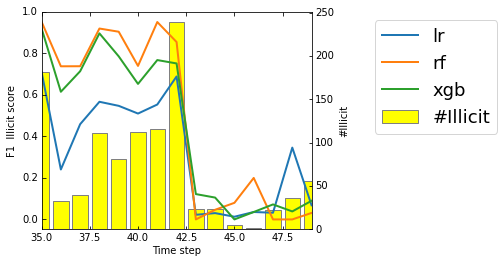

In [103]:
labels = ["lr","rf","xgb"]
plot(logs, labels, illicit_count)

In [104]:
for label in labels:
  print('{}: {}'.format(label, logs[label]['scores']))

lr: {'accuracy': 0.8858428314337132, 'f1': 0.44599708879184863, 'f1_micro': 0.8858428314337132, 'f1_macro': 0.691181122560111, 'precision': 0.32568027210884354, 'recall': 0.7072945521698984}
rf: {'accuracy': 0.9735452909418116, 'f1': 0.7787255393878576, 'f1_micro': 0.9735452909418116, 'f1_macro': 0.8823286037450342, 'precision': 0.8527472527472527, 'recall': 0.716528162511542}
xgb: {'accuracy': 0.9377324535092981, 'f1': 0.613263785394933, 'f1_micro': 0.9377324535092981, 'f1_macro': 0.7897020910273204, 'precision': 0.514053716427233, 'recall': 0.7599261311172668}


#### No SMOTE and SMOTE variants

In [105]:
logs['xgb-smote'], logs['lr-smote'], logs['rf-smote'] = run_all_models(paper_split_data, 'smote')

SMOTE...
Before SMOTE:
0    26432
1     3462
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After SMOTE:
1    26432
0    26432
dtype: int64
linear regression ...
random forest ...
xboost ...


In [106]:
logs['xgb-smenn'], logs['lr-smenn'], logs['rf-smenn'] = run_all_models(paper_split_data, 'smenn')

SMOTE+ENN...
Before SMOTE+ENN:
0    26432
1     3462
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After SMOTE+ENN:
1    26373
0    24461
dtype: int64
linear regression ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


random forest ...
xboost ...


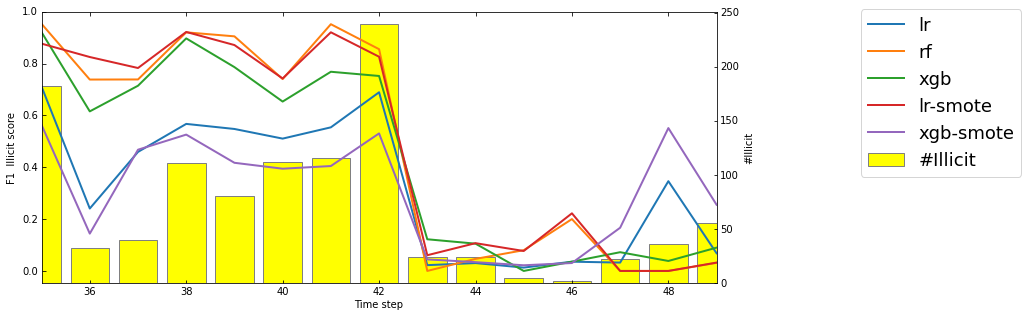

In [182]:
# compare baseline and smote varients
# labels = ["lr","rf","xgb", "lr-smenn","rf-smenn", "xgb-smenn", "lr-smote","rf-smote", "xgb-smote"]
labels = ["lr", "rf","xgb","lr-smote","xgb-smote"]
plot(logs, labels, illicit_count)

In [121]:
labels = ["lr","rf","xgb", "lr-smenn","rf-smenn", "xgb-smenn", "lr-smote","rf-smote", "xgb-smote"]

for label in labels:
  print('{}: {}'.format(label, logs[label]['scores']))

lr: {'accuracy': 0.8858428314337132, 'f1': 0.44599708879184863, 'f1_micro': 0.8858428314337132, 'f1_macro': 0.691181122560111, 'precision': 0.32568027210884354, 'recall': 0.7072945521698984}
rf: {'accuracy': 0.9735452909418116, 'f1': 0.7787255393878576, 'f1_micro': 0.9735452909418116, 'f1_macro': 0.8823286037450342, 'precision': 0.8527472527472527, 'recall': 0.716528162511542}
xgb: {'accuracy': 0.9377324535092981, 'f1': 0.613263785394933, 'f1_micro': 0.9377324535092981, 'f1_macro': 0.7897020910273204, 'precision': 0.514053716427233, 'recall': 0.7599261311172668}
rf-smenn: {'accuracy': 0.9256148770245951, 'f1': 0.4979757085020243, 'f1_micro': 0.9256148770245951, 'f1_macro': 0.7289036300851554, 'precision': 0.4434030281182408, 'recall': 0.5678670360110804}
xgb-smenn: {'accuracy': 0.7425314937012597, 'f1': 0.3061752344002587, 'f1_micro': 0.7425314937012597, 'f1_macro': 0.5740569034931249, 'precision': 0.18557711150303743, 'recall': 0.8744228993536473}
lr-smote: {'accuracy': 0.970005998800

#### Experimental Split

In [111]:
logs['lr-new-split'], logs['rf-new-split'], logs['xgb-new-split'] = run_all_models(experimental_split_data)
logs['lr-new-split-smenn'], logs['rf-new-split-smenn'], logs['xgb-new-split-smenn'] = run_all_models(experimental_split_data, 'smenn')

linear regression ...
random forest ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


xboost ...
SMOTE+ENN...
Before SMOTE+ENN:
0    26981
1     2913
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After SMOTE+ENN:
1    26925
0    24556
dtype: int64
linear regression ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


random forest ...
xboost ...


In [112]:
logs['lr-new-split-smote'], logs['rf-new-split-smote'], logs['xgb-new-split-smote'] = run_all_models(experimental_split_data, 'smote')

SMOTE...
Before SMOTE:
0    26981
1     2913
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After SMOTE:
1    26981
0    26981
dtype: int64
linear regression ...
random forest ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


xboost ...


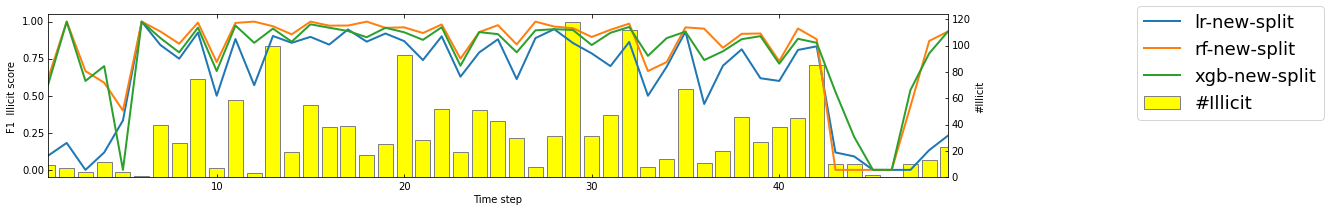

In [150]:
# labels = ["lr-new-split","rf-new-split", "xgb-new-split", "lr-new-split-smote","rf-new-split-smote", "xgb-new-split-smote", "lr-new-split-smenn","rf-new-split-smenn", "xgb-new-split-smenn"]
labels = ["lr-new-split","rf-new-split", "xgb-new-split"]
# illicit_count_ex
plot(logs, labels, illicit_count_ex)

In [114]:
mean_scores = {}
labels = ["lr-new-split","rf-new-split", "xgb-new-split", "lr-new-split-smote","rf-new-split-smote", "xgb-new-split-smote", "lr-new-split-smenn","rf-new-split-smenn", "xgb-new-split-smenn"]
# labels = ["lr-new-split","rf-new-split", "xgb-new-split"] 
for label in labels:
  print('{}: {}'.format(label, logs[label]['scores']))

lr-new-split: {'accuracy': 0.9618476304739052, 'f1': 0.7928338762214984, 'f1_micro': 0.9618476304739052, 'f1_macro': 0.8859114871692229, 'precision': 0.8463143254520167, 'recall': 0.7457107843137255}
rf-new-split: {'accuracy': 0.9868026394721056, 'f1': 0.9283387622149836, 'f1_micro': 0.9868026394721056, 'f1_macro': 0.9605354200899827, 'precision': 0.9909596662030598, 'recall': 0.8731617647058824}
xgb-new-split: {'accuracy': 0.9793641271745651, 'f1': 0.8927680798004988, 'f1_micro': 0.9793641271745651, 'f1_macro': 0.9406758227224982, 'precision': 0.9086294416243654, 'recall': 0.8774509803921569}
lr-new-split-smote: {'accuracy': 0.8965206958608278, 'f1': 0.6369185434645337, 'f1_micro': 0.8965206958608278, 'f1_macro': 0.7882903256341172, 'precision': 0.4850913754408464, 'recall': 0.9270833333333334}
rf-new-split-smote: {'accuracy': 0.9871025794841032, 'f1': 0.9313318428617056, 'f1_micro': 0.9871025794841032, 'f1_macro': 0.9621073792745418, 'precision': 0.9726484322881921, 'recall': 0.89338